In [2]:
import numpy as np 
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline


import time
from sklearn import linear_model
from scipy.stats.stats import pearsonr
import random
from sklearn.linear_model import Ridge

import scipy as scipy
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


In [3]:
nrows_load=600000000
proj_dir="C:\\Users\Rees\\Documents\\Python Scripts\\Kaggle\\Earth Quake Guessing\\all (1)\\"
train = pd.read_csv(proj_dir+"train.csv", nrows=nrows_load)
print("Data Loaded")

Data Loaded


In [14]:
#Chopped data set statistics only
def feature_extractor(xx,cut,fftavg):
    # These are all features, we look at over time
    holder1=[xx[i:i + cut] for i in range(0, len(xx), cut)]
    #mean=np.mean(holder1,1)
    skews=scipy.stats.skew(holder1,1)
    maxxs=np.log(np.max(holder1,1))
    #minss=np.min(holder1,1)
    stdds=np.log(np.std(holder1,1))
    
    kurts=np.log(scipy.stats.kurtosis(holder1,1))
    kurts_nan=np.isnan(kurts)
    kurts[kurts_nan]=0
    
    #These are all global features
    fftmagr=np.log10(np.abs(np.fft.fft(xx)))-fftavg
    ffts0=np.mean(fftmagr[1000:2000])
    ffts1=np.mean(fftmagr[2000:4000])
    ffts2=np.mean(fftmagr[4000:7500])
    ffts3=np.mean(fftmagr[7500:12500])
    ffts4=np.mean(fftmagr[12500:17000])
    ffts5=np.mean(fftmagr[17000:20000])
    ffts6=np.mean(fftmagr[20000:25000])
    return(np.hstack((skews,maxxs,stdds,[ffts0,ffts1,ffts2,ffts3,ffts4,ffts5,ffts6])))

ntrain_pull=100000
start_indices=random.sample(range(1, nrows_load-150000), ntrain_pull)

proj_dir="C:\\Users\Rees\\Documents\\Python Scripts\\Kaggle\\Earth Quake Guessing\\all (1)\\"
data_dir="no_overlap_cuts\\"
data=listdir(proj_dir+data_dir)
listdir(proj_dir+data_dir)
train_set=data[0:4000]

for i in range(4000):
    holder=np.load(proj_dir+data_dir+train_set[i])
    sample1=holder[1]
    fftmag=np.log10(np.abs(np.fft.fft(sample1)))
    fft_Vec.append(fftmag)
allm=np.mean(fft_Vec,0)



cutter=int(150000/20)
x_train_p=[]
y_train=[]
for i in range(ntrain_pull):
    holder=train.acoustic_data.values[start_indices[i]:start_indices[i]+150000]
    if np.size(np.argwhere(np.diff(train.time_to_failure.values[start_indices[i]:start_indices[i]+150000])>0))==0:
        x_train_p.append(feature_extractor(holder,cutter,allm))
        y_train.append(train.time_to_failure.values[start_indices[i]+150000])
        
print("Data Cuts Ready")


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Data Cuts Ready


In [15]:
#Loads the test data set randomly from some precut data
proj_dir="C:\\Users\Rees\\Documents\\Python Scripts\\Kaggle\\Earth Quake Guessing\\all (1)\\"
data_dir="no_overlap_cuts\\"
data=listdir(proj_dir+data_dir)
random.shuffle(data)

ntrain=4000
ntest=150

listdir(proj_dir+data_dir)
train_set=data[0:ntrain]
test_set=data[ntrain+1:ntrain+ntest]

x_test=[]
y_test=[]
for i in range(len(test_set)):
    holder=np.load(proj_dir+data_dir+test_set[i])
    x_test.append(holder[1])
    y_test.append(holder[0][-1])
x_test=np.array(x_test,dtype=float)
y_test=np.array(y_test,dtype=float)
print("Train Set Loaded")

x_test_p=[]
for i in range(len(x_test)):
    x_test_p.append(feature_extractor(x_test[i],cutter,allm))

Train Set Loaded


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [16]:
scaler=StandardScaler()
scaler.fit(x_train_p)
x_train_p_scaled=scaler.transform(x_train_p)
x_test_p_scaled=scaler.transform(x_test_p)

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


example run in 3.04s
Done!
2.024076109756643


(0.6965469241949832, 6.003056072124005e-23)

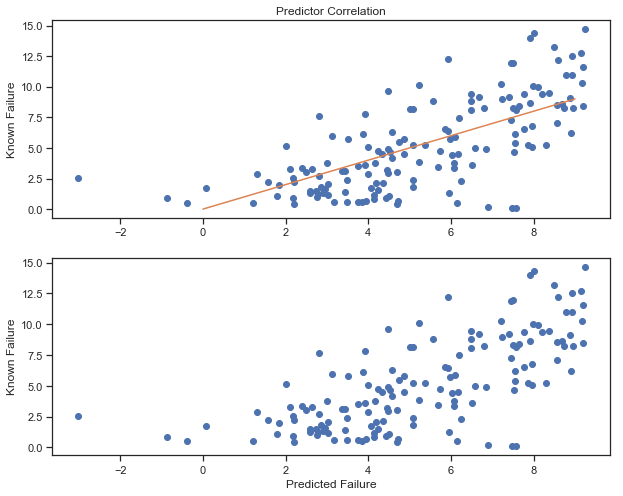

In [17]:
#Initialize the model, and fit to the training
start_time = time.time()


clf = linear_model.SGDRegressor(max_iter=1E2,shuffle=True,eta0=1E-2)
clf.fit(x_train_p_scaled, y_train)

stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))

# Fit the test sample
predicted=clf.predict(x_test_p_scaled)

print("Done!")

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(predicted,y_test,'o')
ax[0].plot(np.array([0,9]),np.array([0,9]))
ax[0].set_ylabel("Known Failure")
ax[0].set_title("Predictor Correlation")

ax[1].plot(predicted,y_test,'o')
ax[1].set_xlabel("Predicted Failure")
ax[1].set_ylabel("Known Failure")


print(np.sum(np.abs(y_test-np.abs(predicted)))/len(y_test))


pearsonr(predicted, y_test)

example run in 4598.46s
Done!
1.933723595434388


(0.740578555858642, 3.681434807630752e-27)

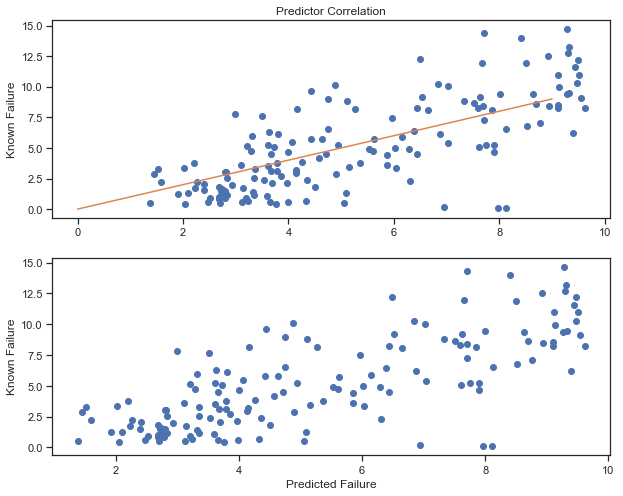

In [18]:
#Initialize the model, and fit to the training
start_time = time.time()


svm = NuSVR()
svm.fit(x_train_p_scaled, y_train)

stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))

# Fit the test sample
predicted=svm.predict(x_test_p_scaled)

print("Done!")

fig, ax = plt.subplots(2,1,figsize=(10,20))
ax[0].plot(predicted,y_test,'o')
ax[0].plot(np.array([0,9]),np.array([0,9]))
ax[0].set_ylabel("Known Failure")
ax[0].set_title("Predictor Correlation")

ax[1].plot(predicted,y_test,'o')
ax[1].set_xlabel("Predicted Failure")
ax[1].set_ylabel("Known Failure")


print(np.sum(np.abs(y_test-predicted))/len(y_test))


pearsonr(predicted, y_test)


example run in 9211.88s
Done!
2.0089201598732345


(0.7106784239459484, 0.0)

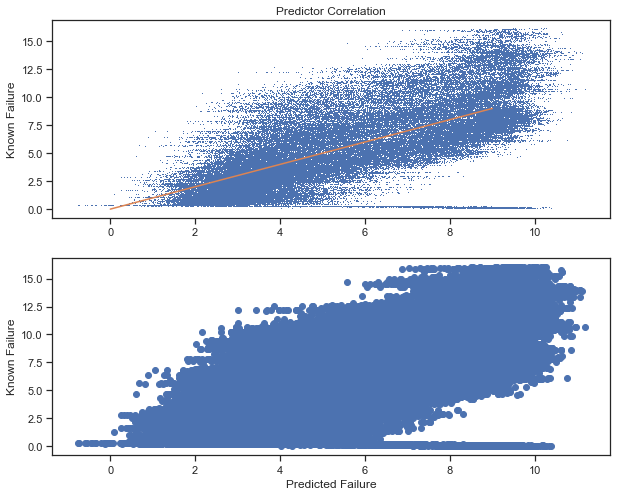

In [20]:
#Initialize the model, and fit to the training
start_time = time.time()


svm = NuSVR()
svm.fit(x_train_p_scaled, y_train)

stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))

# Fit the test sample
predicted=svm.predict(x_train_p_scaled)

print("Done!")

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(predicted,y_train,',')
ax[0].plot(np.array([0,9]),np.array([0,9]))
ax[0].set_ylabel("Known Failure")
ax[0].set_title("Predictor Correlation")

ax[1].plot(predicted,y_train,'o')
ax[1].set_xlabel("Predicted Failure")
ax[1].set_ylabel("Known Failure")


print(np.sum(np.abs(y_train-predicted))/len(y_train))


pearsonr(predicted, y_train)


Text(0.5,1,'Predictor Correlation')

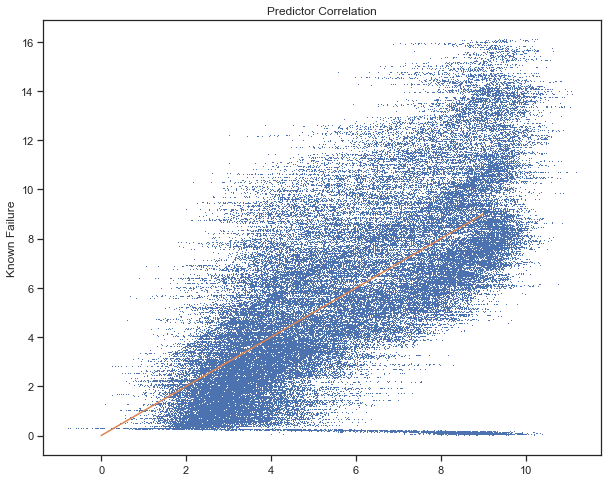

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(predicted,y_train,',')
ax.plot(np.array([0,9]),np.array([0,9]))
ax.set_ylabel("Known Failure")
ax.set_title("Predictor Correlation")


(0, 17)

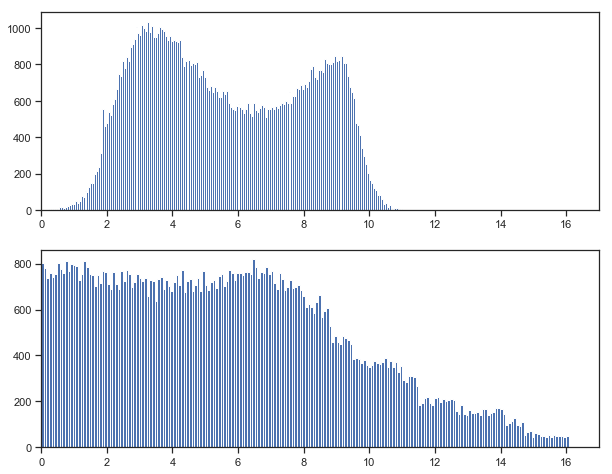

In [31]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].hist(predicted,bins=200);
ax[0].set_xlim([0,17])
ax[1].hist(y_train,bins=200);
ax[1].set_xlim([0,17])

In [32]:
len(y_train)

99640